In [1]:
import pandas as pd

In [2]:
# Load daataset
df = pd.read_csv("creditcard.csv")

In [3]:
df.shape

(284807, 31)

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# Class imbalance:

df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [8]:
df["Class"].value_counts(normalize=True) * 100

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

In [10]:
# The "Time" feature is the number of seconds since the first transaction in the dataset.
# This is the re;ative time not behavioral or real world time.

# Amount feature (key risk signal)

Amount is the tracsaction amount in euros, not scaled but highly skewed due to the presence of some small and few large values.

In fraud etection
- very small amounts --> often testing cards
- very large amounts --> high-risk transaction 
- sudden change in amount --> suspicious behavious

In [9]:
# Distribution of Amount

df["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [10]:
df["Amount"].median()

22.0

The Amount feature is heavily right-skewed, with most transactions being low-value and a small number of very large transactions pulling the mean far above the median, which is typical in payment and fraud data

In [11]:
# Distribution no Time

df["Time"].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

In [12]:
df["Time"].median()

84692.0

The Time feature represents a continuous transaction timeline over roughly two days; its distribution does not need to be normal because it encodes sequence order rather than a random variable.

# PCA Features (V1 - V28)

Each row in this dataset represents a single credit card transaction.
The features V1 to V28 are PCA-transformed components derived from the original transaction attributes. These original features were anonymised to protect sensitive financial information, which is common practice in fraud detection datasets.

Although individual PCA components are not directly interpretable, they still encode important behavioural and transactional patterns. Tree-based and ensemble models can effectively learn from these features without requiring semantic meaning. In real-world fraud detection systems, working with encoded or obfuscated signals like these is standard.

# Feature Engineering

In [13]:
# Log-transformed Amount

import numpy as np

df["Amount_log"] = np.log1p(df["Amount"])  # Handles zero values safely, Standard practice in payments data

In [14]:
# Scaling (scale amount)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df["Amount_scaled"] = scaler.fit_transform(df[["Amount"]])

In [15]:
df["Time_bin"] = pd.cut(df["Time"], bins=10)

# We bin time to tell the model whether a transaction happened early, middle, or late in the dataset
# instead of using an exact second value that has no meaning by itself.

Feature engineering was intentionally minimal and fraud-aware. PCA-transformed features (V1–V28) were left untouched, as they already encode anonymised behavioural signals. A log-transformed version of transaction amount was added to stabilise skewed values, and a coarse time bin was introduced to capture temporal phases without introducing leakage. No user-level or velocity features were created due to the absence of entity identifiers.

# Baseline Model (Logistic Regression)

In [21]:
# Target
y = df["Class"]

# Features
x = df.drop(columns=["Class"])

In [22]:
# one-hot encoding for categoical data i_e Time_bin)

x = pd.get_dummies(x, columns=["Time_bin"], drop_first=True)

In [23]:
# Train / test splt

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [24]:
# Fit Logistic Regression

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(x_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [25]:
y_pred = log_reg.predict(x_test)
y_proba = log_reg.predict_proba(x_test)[:, 1]


In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm


array([[54949,  1915],
       [    9,    89]], dtype=int64)

In [28]:
# Evaluation

from sklearn.metrics import classification_report, roc_auc_score

y_pred = log_reg.predict(x_test)
y_proba = log_reg.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.04      0.91      0.08        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.97      0.98     56962

ROC-AUC: 0.9712744622328391


### Precision-Recall Curve (Baseline Model)


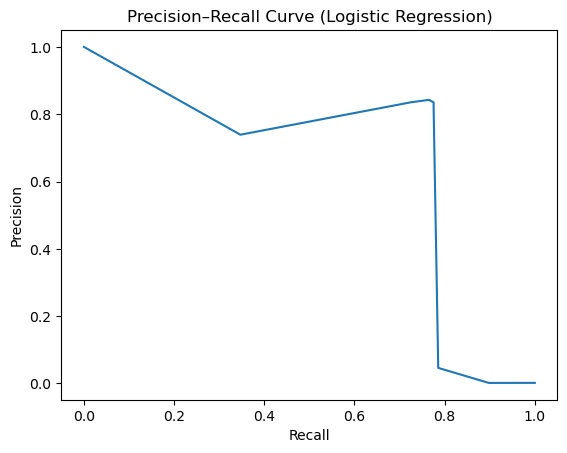

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.show()


# Logistic Regression - Summary & Conclusion

Logistic Regression was used as a baseline model for the fraud detection task. Due to the extreme class imbalance, model performance was evaluated using recall, precision, ROC-AUC, and the confusion matrix rather than accuracy.

The model achieved high fraud recall (≈ 0.91), meaning it successfully detected most fraudulent transactions. However, fraud precision was very low (≈ 0.04), indicating that a large number of legitimate transactions were incorrectly flagged as fraud. This behaviour is evident in the confusion matrix, where false positives significantly outnumber true positives. The Precision–Recall curve further highlights this issue, showing a sharp decline in precision as recall increases, which confirms that improving fraud coverage quickly leads to excessive false alarms.

Despite these limitations, the model achieved a strong ROC-AUC (≈ 0.97), demonstrating that it is effective at ranking fraudulent transactions higher than legitimate ones. Overall, this baseline shows that while Logistic Regression captures useful signal, its single linear decision boundary results in an unfavourable error pattern for deployment. Further tuning would primarily shift the precision–recall trade-off without addressing this structural limitation. Therefore, we proceed to a Decision Tree model to explore non-linear decision rules and feature interactions that may reduce false positives and produce a more operationally suitable error distribution.

# Single Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    random_state=42
)

dt.fit(x_train, y_train)


DecisionTreeClassifier(random_state=42)

# Evaluation of Decission Tree

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred_dt = dt.predict(x_test)
y_proba_dt = dt.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dt))

confusion_matrix(y_test, y_pred_dt)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.76      0.73        98

    accuracy                           1.00     56962
   macro avg       0.85      0.88      0.86     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.8772696473074317


array([[56832,    32],
       [   24,    74]], dtype=int64)

In [33]:
# Check tree depth

dt.get_depth(), dt.get_n_leaves()


(26, 161)

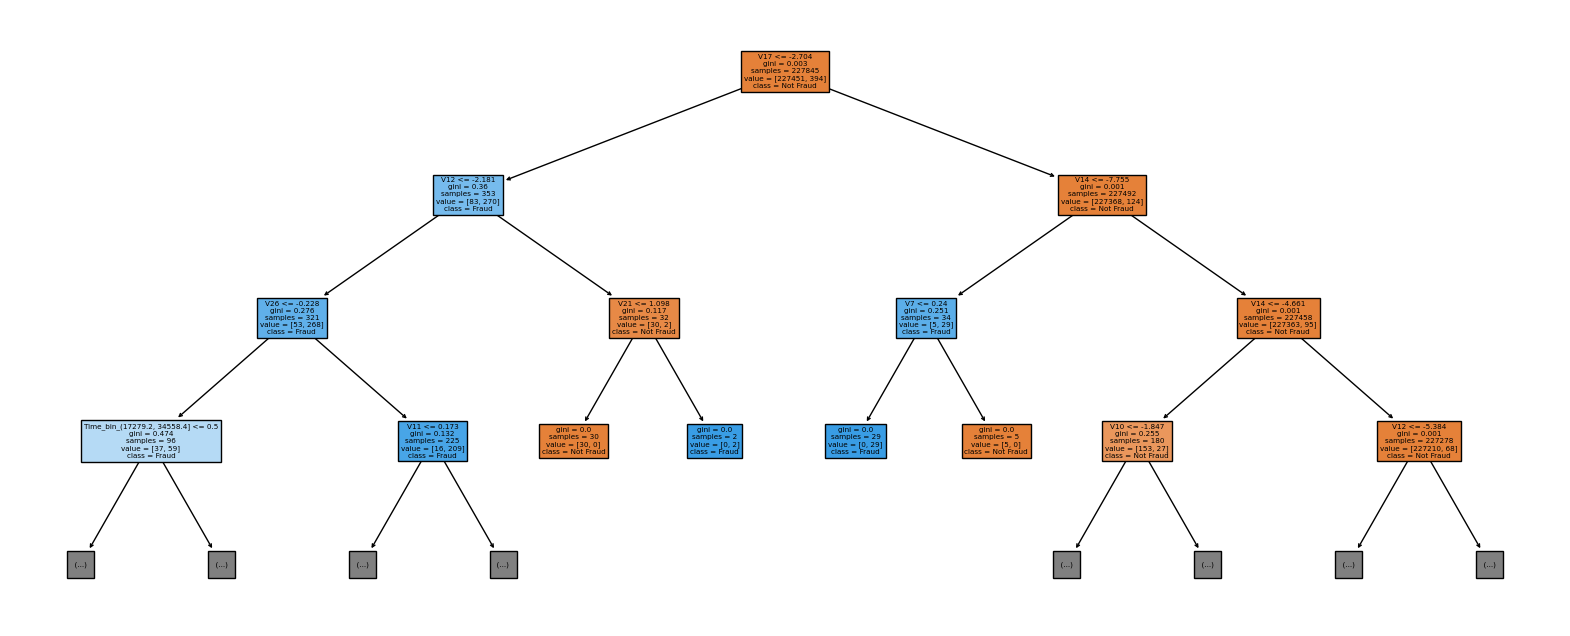

In [34]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plot_tree(
    dt,
    max_depth=3,
    feature_names=x_train.columns,
    class_names=["Not Fraud", "Fraud"],
    filled=True
)
plt.show()


# Single Decision Tree – Evaluation Summary

A single, unconstrained Decision Tree was trained to explore non-linear decision rules in fraud detection. Compared to Logistic Regression, the tree achieved significantly higher fraud precision (~70%), greatly reducing false positives, but at the cost of lower fraud recall (~76%), resulting in more missed fraud cases. The confusion matrix highlights this trade-off clearly.

The model exhibited a deep structure (depth = 26 with 161 leaves), indicating overfitting and sensitivity to noise. While the Decision Tree demonstrates the value of non-linear rules and improves precision, its instability and tendency to overfit make it unsuitable for direct production use. This motivates the transition to ensemble methods, which combine multiple trees to improve stability and generalisation.

# Train trees with controlled depth

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

depths = [3, 5, 8]

for d in depths:
    print(f"\n--- Decision Tree (max_depth={d}) ---")
    
    dt_ctrl = DecisionTreeClassifier(
        max_depth=d,
        random_state=42
    )
    
    dt_ctrl.fit(x_train, y_train)
    
    y_pred = dt_ctrl.predict(x_test)
    y_proba = dt_ctrl.predict_proba(x_test)[:, 1]
    
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# Decision Tree Depth Analysis - Summary

Decision Trees were evaluated with different maximum depths to understand the impact of model complexity on fraud detection performance. Shallow trees (e.g., max_depth=3) produced stable but overly simple rules, resulting in lower fraud recall. Increasing depth to a moderate level (max_depth=5) achieved the best balance between fraud precision and recall, significantly reducing false positives while maintaining acceptable fraud detection. However, further increasing depth (max_depth=8) led to over-specific decision rules, causing a decline in recall and an increase in missed fraud cases. This demonstrates that increasing tree depth does not guarantee better performance and that single Decision Trees remain sensitive to depth selection and data variation.

Although a moderately deep Decision Tree performs reasonably well, it remains a single model and is therefore vulnerable to instability and overfitting. Random Forest addresses these limitations by combining multiple decision trees trained on different data and feature subsets, averaging their predictions to reduce variance and improve robustness. This allows Random Forest to preserve the non-linear decision power of trees while delivering more stable and operationally reliable fraud detection performance, making it a more suitable choice for real-world deployment.

# Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=100,   # no of trees
    random_state=42,
    n_jobs=-1
)

rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_test)
y_proba_rf = rf.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9528134797813329
Confusion Matrix:
 [[56859     5]
 [   17    81]]


### Feature Importance (Random Forest)


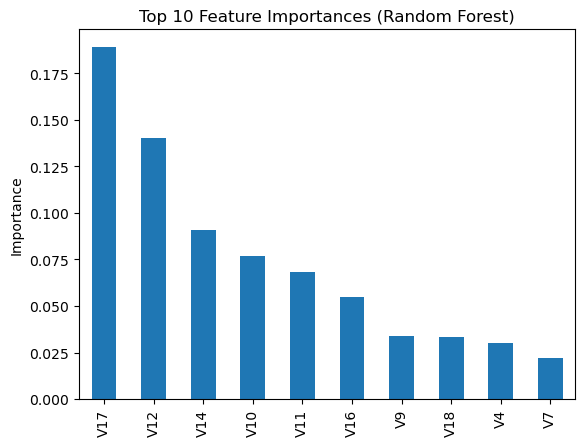

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = x_train.columns

feat_imp = pd.Series(importances, index=feature_names)
top_features = feat_imp.sort_values(ascending=False).head(10)

plt.figure()
top_features.plot(kind="bar")
plt.ylabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


This project explored fraud detection on a highly imbalanced credit card transactions dataset, progressing from simple baseline models to a robust ensemble approach. The workflow began with Logistic Regression, which demonstrated strong ranking capability, as reflected by a high ROC-AUC, but generated an impractically large number of false positives. This made it unsuitable for direct deployment despite its high fraud recall. A Decision Tree model was then evaluated at varying maximum depths to analyse the impact of model complexity. While a moderately deep tree achieved a reasonable balance between precision and recall, the model remained sensitive to depth selection and data variation, limiting its reliability.

To overcome these limitations, a Random Forest model was adopted as the final solution. By aggregating predictions from multiple decision trees trained on different bootstrap samples and feature subsets, the Random Forest significantly reduced variance and delivered a more stable error profile. The model achieved high fraud precision, strong recall, and a very low false positive rate, making it operationally realistic for fraud detection. This progression highlights why ensemble methods are preferred over single models in real-world fraud systems, where stability, customer experience, and controlled error trade-offs are essential. Based on these considerations, the Random Forest was selected as the most suitable model for deployment.